In [39]:
import sys
path_to_code_folder = '/Users/maor/Desktop/NLP' # change this to your local procject path
sys.path.insert(0,path_to_code_folder )

In [40]:
from operator import itemgetter
from tqdm import tqdm
import math
import data_preparation as dp
from data_preprocessing import preprocessing, split_by_space
from language_model import LM
import glob
from pathlib import Path
from performance_measures import *
from Query import *


We will use <b>query likelihood retrieval</b> score as reference to the approach suggest in the article

in the artical all experiments strat  from a set of previously retrieved results obtained using the basic query-likelihood ranking function and Dirichlet smoothing.


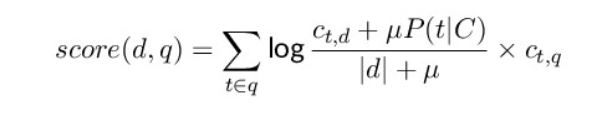

In [41]:
def get_query_likelihood_retrieval_score(query_words, docs_lm):

    # Analysis query words
    result = []

    for doc_lm in docs_lm:

        query_likelihood_score = 0
        lm = docs_lm[doc_lm]
        # score = log p(q|d) => score = sum [ c(t|q)*log(P(t|d)) ]

        for qw in query_words:
            c_w_q = query_words[qw]
            if qw in lm.keys():
                p_w_c = lm[qw]
            else:
                continue

            log_pd = float(math.log(float(p_w_c), 2))*c_w_q
            query_likelihood_score += log_pd

        # Add to result
        result.append((doc_lm, query_likelihood_score))
    # Sort & return
    return sorted(result, key=itemgetter(1), reverse=True)


in each experimen we calculate <b>KL divergence</b> between the new query LM and each document for get the retrieval score
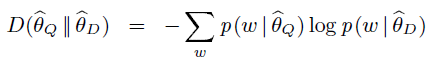

In [42]:
def get_KL_retrieval_score(query_lm, docs_lm):

    # Analysis query words
    result = []

    for doc in docs_lm:

        kl_score = 0.0

        doc_lm = docs_lm[doc]
        # score += -p(t|q)*log(P(t|d))
        for qw in query_lm:
            ptq = query_lm[qw]
            if qw in doc_lm.keys():
                ptd = doc_lm[qw]
            else:
                ptd = 1
            log_ptd = math.log(ptd, 2)
            kl_score += -ptq * log_ptd
        # Add to result
        result.append((doc, kl_score))
    # Sort & return
    return sorted(result, key=itemgetter(1), reverse=False)


in this notebook we will use the <b>KL DIVERGENCE MINIMIZATION</b> method suggested in the artical to estimate the feedback LM.
the average divregence form feedback documents to the query will be
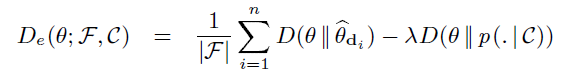

and the estimated feedback LM will be

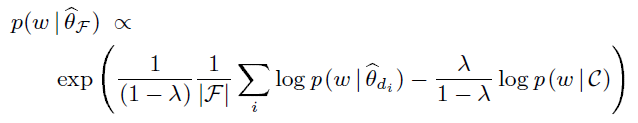

In [43]:
def get_feedback_lm_by_KL(top_n_docs, docs_lm, bg_lm, lamda=0.2):

    # Analysis query words
    cutoff_prob = 0.001
    feedback_lm = LM()
    word_list = []

    # add all words in all docs to one list
    for doc in top_n_docs:
        for word in docs_lm[doc]:
            if word not in word_list:
                word_list.append(word)
    sum = 0

    # for each word in the word list calc th prob
    for word in word_list:
        p_w_d = 0
        p_w_c = 0

        # get the word prob in the collection
        if word in bg_lm:
            p_w_c = math.log(bg_lm[word])

        # get the word prob in each doc ( if word is in the doc)
        for doc in top_n_docs:
            if word in docs_lm[doc]:
                p_w_d += math.log(docs_lm[doc][word])

        # calc the p(w|f) for each word to build feedback lam
        p_w_f = math.exp((float(p_w_d)/(float(1-lamda)*len(top_n_docs))) - float(p_w_c)*(float(lamda)/float(1-lamda)))

        # add the word to the lm only if the prob > cutff prob
        if p_w_f > cutoff_prob:
            sum += p_w_f
            feedback_lm.lm[word] = p_w_f

    # re normalized he feedback lm
    for word in feedback_lm.lm:
        feedback_lm.lm[word] = feedback_lm.lm[word]/sum
    return feedback_lm.lm


after estimate the feedback LM we will <b>update the query LM using linear interpolation</b> between ther original query LM and the estimate feeback LM

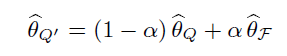

In [44]:
def update_query_lm(query_lm, alpha, feedback_lm):

    # Analysis query words
    new_query_lm = LM()
    for word in feedback_lm:

        # update the query lm for words in feedback lm
        if word in query_lm:
            p_w = (1-alpha)*query_lm[word] + alpha*feedback_lm[word]
        else:

            p_w = alpha*feedback_lm[word]
        if p_w > 0:
            new_query_lm.lm[word] = p_w

    # update the query lm for words that not in feedback lm
    for word in query_lm:
        if word not in new_query_lm.lm:
            p_w = (1-alpha)*query_lm[word]
            new_query_lm.lm[word] = p_w

    return new_query_lm.lm


we will use the CISI dataset in our experment.
this dataset contines 1460 documents and 112 associated queries

https://www.kaggle.com/dmaso01dsta/cisi-a-dataset-for-information-retrieval

#### Document in the dataset looks like this:

.I 1  
.T  
18 Editions of the Dewey Decimal Classifications  
.A  
Comaromi, J.P.  
.W  
   The present study is a history of the DEWEY Decimal  
Classification.  The first edition of the DDC was published  
in 1876, the eighteenth edition in 1971, and future editions  
will continue to appear as needed.  In spite of the DDC's  
long and healthy life, however, its full story has never  
been told.  There have been biographies of Dewey  
that briefly describe his system, but this is the first  
attempt to provide a detailed history of the work that  
more than any other has spurred the growth of  
librarianship in this country and abroad.  
.X  
1	5	1  
92	1	1  
262	1	1  
556	1	1  
1004	1	1  
1024	1	1  
1024	1	1  

we take the uninq id form(.I)
and as content we use the title-(.T), author(.A) and the abstract(.W)

#### query in the dataset is look like this :

.I 12  
.W  
Give methods for high speed publication, printing, and distribution of
scientific journals.

we take from the uninq id form (.I)
and as query we use the query text (.W)

the dataset also containing a mapping file of query id to document id 
we use this file as the ground truth for measure our result 

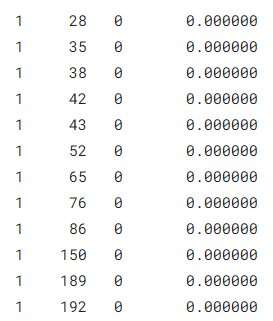

### Retrieval process as presented in the article

first we crate a unigram LM for the collection of documents using Maximum liklihood and save it to the disc as csv file

then we create a unigram LM for each document using Dirichlet smoothing(using μ as average document legnth)

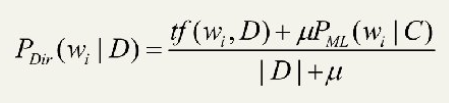

#### load the LM for docs and collection

In [45]:
bglm_file_name = 'BGLM.csv'
bglm = LM()
bg_lm = bglm.load_lm_from_file(bglm_file_name)

In [46]:
docs_lm_path = 'DocsLm/'
docs_list = [f for f in glob.glob("{0}*.csv".format(docs_lm_path))]
docs_lm_dict = {}

for doc in tqdm(docs_list, desc="Loading documents LM"):
    dlm = LM()
    doc_id = int((Path(doc).stem.split('_')[1].lstrip('0')))
    docs_lm_dict[doc_id] = dlm.load_lm_from_file(doc)


Loading documents LM: 100%|████████████████████████████████████████████████████████| 1460/1460 [00:21<00:00, 69.29it/s]


set const to :  
<b> N = 50 </b> the number of retrieval docs  
<b>TopN = 3 </b>the number of documents using for feedback LM estimate  
we use only 50 documents and 3 documents for feedback becaues our dataset is too small  
<b>α = 0.5 </b>- coefficient for the linear interpolation  
<b>λ = 0.5 </b> - coefficient of the collection LM in the estimate feedback Lm equation

In [47]:
N = 50  # the number of retrieval docs to take for performance measures
topN = 3  # number of docs to use in feedback
alpha = 0.5
lamda = 0.5

#### load queris and ground truth

In [48]:
queries = dp.get_queries()
ground_truth = dp.get_ground_truth()  # load ground truth

for example we pick one query

In [49]:
query_num = 50

pre processing the query (using Porter stemming and remove punctuation)

In [50]:
query = Query(query_num)
query_term = queries[str(query_num)]
print(query_term)
query_term = preprocessing(query_term, stopwords= False)
words = split_by_space(query_term)
print(words)
query.SetWords(words)

Is there any use for traditional classification schemes - DDC, UDC, LC, etc. - in information retrieval systems?  If there is, which scheme appears most suited to machine use and where has it been applied? If there is not, why are these classification schemes irrelevant? Has research shown that a subject classification of knowledge is completely unnecessary in machine systems? Or, have new schemes been devised which appear to be more suited to machine use?
['is', 'there', 'ani', 'use', 'for', 'tradit', 'classif', 'scheme', 'ddc', 'udc', 'lc', 'etc', 'in', 'inform', 'retriev', 'system', 'if', 'there', 'is', 'which', 'scheme', 'appear', 'most', 'suit', 'to', 'machin', 'use', 'and', 'where', 'ha', 'it', 'been', 'appli', 'if', 'there', 'is', 'not', 'whi', 'are', 'these', 'classif', 'scheme', 'irrelev', 'ha', 'research', 'shown', 'that', 'a', 'subject', 'classif', 'of', 'knowledg', 'is', 'complet', 'unnecessari', 'in', 'machin', 'system', 'or', 'have', 'new', 'scheme', 'been', 'devis', 'whi

build the query LM for this query (using Maximum Likelihood) and calculate the query likelihood score and the KL retrieva score for this query

In [51]:
query.likelihood_retrieval_score = get_query_likelihood_retrieval_score(query.words, docs_lm_dict)
qlm = LM()
query.base_lm = qlm.unigram_ml_lm(query.words, query.GetQueryLen())
query.KL_retrieval_score = get_KL_retrieval_score(query.base_lm, docs_lm_dict)

display the first 10 documents for each retriveal method

In [52]:
top_query_likelihood = []
for x in range(1,10):top_query_likelihood.append(query.likelihood_retrieval_score[x][0])
print("top 10 documents after simple query likelihood retrieval")
print (top_query_likelihood)

print("top 10 documents after KL retrieval")
top_KL = []
for x in range(1,10):top_KL.append(query.KL_retrieval_score[x][0])
print (top_KL)

top 10 documents after simple query likelihood retrieval
[838, 261, 746, 1, 1177, 1446, 478, 931, 485]
top 10 documents after KL retrieval
[838, 261, 746, 1, 1177, 1446, 478, 931, 485]


calculate the average precision and recall

In [53]:
likelihood_retrieval_score = query.likelihood_retrieval_score
total_retrieved, total_relevant, avg_precision, likelihood_N_docs = performance_measures(N,
                                                                              likelihood_retrieval_score,
                                                                              query_num,
                                                                              ground_truth)

print(f'retrieved : {total_retrieved} form {total_relevant} relevant\navg precision {avg_precision}\nrecall {total_retrieved/total_relevant}')

retrieved : 18 form 50 relevant
avg precision 0.505442614283194
recall 0.36


In [54]:
kl_retrieval_score = query.KL_retrieval_score
total_retrieved, total_relevant, avg_precision, N_docs = performance_measures(N,
                                                                              kl_retrieval_score,
                                                                              query_num,
                                                                              ground_truth)
print(f'retrieved : {total_retrieved} form {total_relevant} relevant\navg precision {avg_precision}\nrecall {total_retrieved/total_relevant}')

retrieved : 18 form 50 relevant
avg precision 0.505442614283194
recall 0.36


#### We can see that in both retrieval method we get the same results

## retrieval using feedback 

In [55]:
# KL feedback + KL retrieval after QL retrieval
feedback_lm = get_feedback_lm_by_KL(likelihood_N_docs[:topN], docs_lm_dict, bg_lm, lamda)
new_q_lm = update_query_lm(query.base_lm, alpha, feedback_lm)
feedback_score = get_KL_retrieval_score(new_q_lm, docs_lm_dict)
total_retrieved, total_relevant, avg_precision, N_docs = performance_measures(N,
                                                                              feedback_score,
                                                                              query_num,
                                                                              ground_truth)

the top 10 documents after feedback

In [56]:
print("top 10 documents after KL retrieval with feedback")
top_KL_feedback = []
for x in range(1,10):top_KL_feedback.append(feedback_score[x][0])
print (top_KL_feedback)

top 10 documents after KL retrieval with feedback
[388, 838, 485, 1430, 539, 1165, 263, 931, 1115]


calculate the average precision and recall

In [57]:
print(f'retrieved : {total_retrieved} form {total_relevant} relevant\navg precision {avg_precision}\nrecall {total_retrieved/total_relevant}')

retrieved : 19 form 50 relevant
avg precision 0.4610448502872958
recall 0.38


We can see that in get better results in recall but decline in precision etjwhen using feedback

## new feedback method

we suggest <b> new method for the Kl Minimization divregence</b> method:  
instead of using avarge divregence we will <b>use weighted arithmetic mean</b> To give to an higher rank document more influence on the feedback documents divergence from the query  

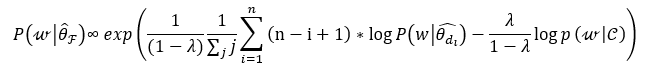

In [58]:
def get_feedback_lm_by_KL_new_approche(top_n_docs, docs_lm, bg_lm, lamda=0.2):

    # Analysis query words
    cutoff_prob = 0.001
    feedback_lm = LM()
    word_list = []
    n = len(top_n_docs)
    topn_sum = np.sum(list(range(1, n+1)))

    # add all words in all docs to one list
    for doc in top_n_docs:
        for word in docs_lm[doc]:
            if word not in word_list:
                word_list.append(word)
    sum = 0

    # for each word in the word list calc th prob
    for word in word_list:
        p_w_d = 0
        p_w_c = 0

        # get the word prob in the collection
        if word in bg_lm:
            p_w_c = math.log(bg_lm[word])

        # get the word prob in each doc ( if word is in the doc)
        i = 0
        for doc in top_n_docs:
            if word in docs_lm[doc]:
                p_w_d += math.log(docs_lm[doc][word])*(n-i)
                i += 1
        # calc the p(w|f) for each word to build feedback lam
        p_w_f = math.exp((float(p_w_d)/(float(1-lamda)*topn_sum)) - float(p_w_c)*(float(lamda)/float(1-lamda)))

        # add the word to the lm only if the prob > cutff prob
        if p_w_f > cutoff_prob:
            sum += p_w_f
            feedback_lm.lm[word] = p_w_f

    # re normalized he feedback lm
    for word in feedback_lm.lm:
        feedback_lm.lm[word] = feedback_lm.lm[word]/sum
    return feedback_lm.lm


In [59]:

feedback_lm = get_feedback_lm_by_KL_new_approche(likelihood_N_docs[:topN], docs_lm_dict, bg_lm, lamda)
new_q_lm = update_query_lm(query.base_lm, alpha, feedback_lm)

new_feedback_score = get_KL_retrieval_score(new_q_lm, docs_lm_dict)
total_retrieved, total_relevant, avg_precision, N_docs = performance_measures(N,
                                                                              new_feedback_score,
                                                                              query_num,
                                                                              ground_truth)

In [60]:
print("top 10 documents after KL retrieval with new feedback")
top_KL_feedback_new = []
for x in range(1,10):top_KL_feedback_new.append(new_feedback_score[x][0])
print (top_KL_feedback_new)

top 10 documents after KL retrieval with new feedback
[261, 838, 485, 1430, 539, 1165, 1115, 931, 1074]


In [61]:
print(f'retrieved : {total_retrieved} form {total_relevant} relevant\navg precision {avg_precision}\nrecall {total_retrieved/total_relevant}')

retrieved : 21 form 50 relevant
avg precision 0.5024395200532689
recall 0.42


For this query we see better recall and more or less the same result in precision

# EXPERIMENTS

we measure the result for the all collection of query
we save the result to 3 diffrent csv files:
1. performance for each one of of the method with <b> fixed</b> value for <b> α and λ</b>
2. performance for each one of the methos with  <b> fixed </b> value for  <b> α</b> but  <b> different</b> values for  <b> λ</b>
3. performance for each one of the methos with  <b> fixed</b> value for  <b> λ</b> but  <b> different</b> values for  <b> α</b>
    
    


In [62]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

## Total performance at Top50 retrieved documents
## α = λ = 0.5

In [63]:
df = pd.read_csv('result\Top50.csv')
# display DataFrame
display(df)
df.set_index("Method", inplace = True)

,Method,AvgPr,Recall,lamda,alpha
0,simple LM,0.399736,558/2302,0.5,0.5
1,KL,0.399736,558/2302,0.5,0.5
2,Min KL,0.404193,592/2302,0.5,0.5
3,Min KL NEW,0.397873,600/2302,0.5,0.5


In [64]:
kl_Feedback_AvgPr_Improve = ((df.loc['Min KL']['AvgPr']/df.loc['simple LM']['AvgPr']) -1) * 100
new_kl_Feedback_AvgPr_Improve = ((df.loc['Min KL NEW']['AvgPr']/df.loc['simple LM']['AvgPr'])-1) * 100

In [65]:
print(f'Average precision improv in KL divergence minimization method : {kl_Feedback_AvgPr_Improve} %')
print(f'Average precision improv in suggested KL divergence minimization method : {new_kl_Feedback_AvgPr_Improve} %')

Average precision improv in KL divergence minimization method : 1.1150231294418722 %
Average precision improv in suggested KL divergence minimization method : -0.4659047569014696 %


the KL feedback improves the precision result by 1.15%  
the new feedback method lowers the precision by 0.46%

In [66]:
kl_Feedback_Recall_Improve = (( eval(df.loc['Min KL']['Recall'])/ eval(df.loc['simple LM']['Recall'])) -1) * 100
new_kl_Feedback_Recall_Improve = ((eval(df.loc['Min KL NEW']['Recall'])/ eval(df.loc['simple LM']['Recall']))-1) * 100

In [67]:
print(f'Recall improv in KL divergence minimization method : {kl_Feedback_Recall_Improve} %')
print(f'Recall improv in suggested KL divergence minimization method : {new_kl_Feedback_Recall_Improve} %')

Recall improv in KL divergence minimization method : 6.093189964157708 %
Recall improv in suggested KL divergence minimization method : 7.526881720430101 %


the KL feedback improves the precision result by 6.09%  
the new feedbak method improves the precision by 7.52%

## performance at Top50 retrieved documents
## α in rnage [0,1] and λ = 0.5

In [68]:
df = pd.read_csv('result\Top50_alpha_values.csv')
# display DataFrame
display(df)
df.set_index("Method", inplace = True)

,Method,AvgPr,Recall,lamda,alpha
0,simple LM,0.399736,558/2302,0.5,0.0
1,KL,0.399736,558/2302,0.5,0.0
2,Min KL,0.399736,558/2302,0.5,0.0
3,Min KL NEW,0.399736,558/2302,0.5,0.0
4,simple LM,0.399736,558/2302,0.5,0.1
5,KL,0.399736,558/2302,0.5,0.1
6,Min KL,0.415183,567/2302,0.5,0.1
7,Min KL NEW,0.420812,574/2302,0.5,0.1
8,Min KL NEW,0.417905,585/2302,0.5,0.2
9,Min KL,0.410199,579/2302,0.5,0.2


In [69]:
alpha = np.linspace(0, 1, 11)
simple_LM_Avg_Pr = (df.loc['simple LM']['AvgPr']).values
KL_Avg_Pr = (df.loc['KL']['AvgPr']).values
Min_KL_Avg_Pr = (df.loc['Min KL']['AvgPr']).values
Min_KL_NEW_Pr = (df.loc['Min KL NEW']['AvgPr']).values


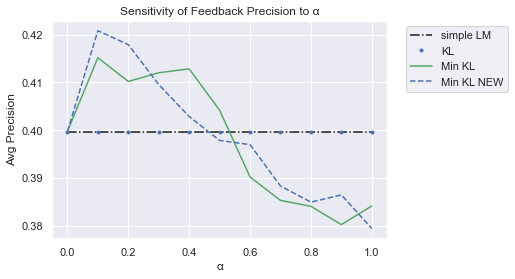

In [70]:
plt.plot(alpha, simple_LM_Avg_Pr, '-.k', label='simple LM')
plt.plot(alpha, KL_Avg_Pr, '.b', label='KL')
plt.plot(alpha, Min_KL_Avg_Pr, '-g', label='Min KL')
plt.plot(alpha, Min_KL_NEW_Pr, '--b', label='Min KL NEW')
plt.title("Sensitivity of Feedback Precision to α")
plt.xlabel("α")
plt.ylabel("Avg Precision");
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

Both feedback methods achieve better precsion in relation to the simple LM or KL retrieval when α < 0.5  
the mew feedback method achieve better result form the KL feedback when α is in range [0,0.3]

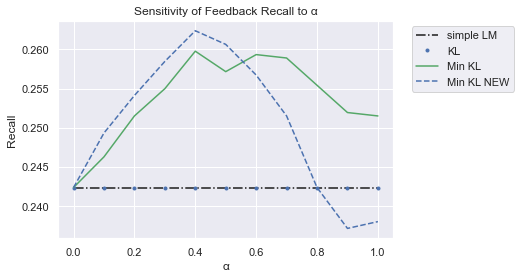

In [71]:
simple_LM_Recall = ((df.loc['simple LM']['Recall']).values)
KL_Recalll = (df.loc['KL']['Recall']).values
Min_KL_Recall = (df.loc['Min KL']['Recall']).values
Min_KL_NEW_Recall = (df.loc['Min KL NEW']['Recall']).values

simple_LM_Recall = [eval(numeric_string) for numeric_string in simple_LM_Recall]
KL_Recalll = [eval(numeric_string) for numeric_string in KL_Recalll]
Min_KL_Recall = [eval(numeric_string) for numeric_string in Min_KL_Recall]
Min_KL_NEW_Recall = [eval(numeric_string) for numeric_string in Min_KL_NEW_Recall]

plt.plot(alpha, simple_LM_Recall, '-.k', label='simple LM')
plt.plot(alpha, KL_Recalll, '.b', label='KL')
plt.plot(alpha, Min_KL_Recall, '-g', label='Min KL')
plt.plot(alpha, Min_KL_NEW_Recall, '--b', label='Min KL NEW')
plt.title("Sensitivity of Feedback Recall to α")
plt.xlabel("α")
plt.ylabel("Recall");
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

KL feedback method achieve better recall in relation to the simple LM or KL retrieval in all α values  
the mew feedback method achieve better recall in relation to the simple LM or KL retrieval when α < 0.8 

## performance at Top50 retrieved documents
## λ in rnage [0,1) and α = 0.5

In [72]:
df = pd.read_csv('result\Top50_lamda_values.csv')
# display DataFrame
display(df)
df.set_index("Method", inplace = True)

,Method,AvgPr,Recall,lamda,alpha
0,simple LM,0.399736,558/2302,0.00,0.5
1,KL,0.399736,558/2302,0.00,0.5
2,Min KL,0.397706,540/2302,0.00,0.5
3,Min KL NEW,0.388485,548/2302,0.00,0.5
4,simple LM,0.399736,558/2302,0.10,0.5
5,KL,0.399736,558/2302,0.10,0.5
6,Min KL,0.401223,546/2302,0.10,0.5
7,Min KL NEW,0.397569,550/2302,0.10,0.5
8,Min KL NEW,0.404228,566/2302,0.20,0.5
9,Min KL,0.396178,560/2302,0.20,0.5


In [73]:
lamda = np.linspace(0, 1, 11)
lamda[-1] = 0.98
simple_LM_Avg_Pr = (df.loc['simple LM']['AvgPr']).values
KL_Avg_Pr = (df.loc['KL']['AvgPr']).values
Min_KL_Avg_Pr = (df.loc['Min KL']['AvgPr']).values
Min_KL_NEW_Pr = (df.loc['Min KL NEW']['AvgPr']).values

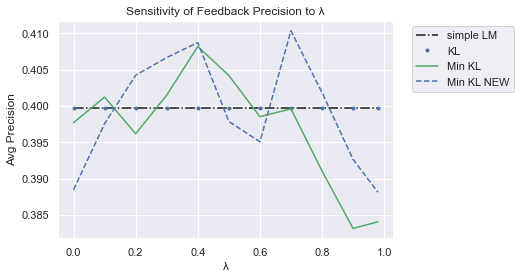

In [74]:
plt.plot(lamda, simple_LM_Avg_Pr, '-.k', label='simple LM')
plt.plot(lamda, KL_Avg_Pr, '.b', label='KL')
plt.plot(lamda, Min_KL_Avg_Pr, '-g', label='Min KL')
plt.plot(lamda, Min_KL_NEW_Pr, '--b', label='Min KL NEW')
plt.title("Sensitivity of Feedback Precision to λ")
plt.xlabel("λ")
plt.ylabel("Avg Precision");
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

Both feedback methos precision seems to be sensitive  to λ  
KL feedback gets good precision result when λ is in range [0.25,0.6]  
the new feedback gets goot precision result when λ is in range [0.15,0.5] and [0.65,0.8]

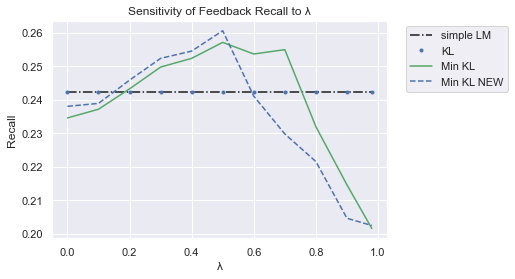

In [75]:
simple_LM_Recall = ((df.loc['simple LM']['Recall']).values)
KL_Recalll = (df.loc['KL']['Recall']).values
Min_KL_Recall = (df.loc['Min KL']['Recall']).values
Min_KL_NEW_Recall = (df.loc['Min KL NEW']['Recall']).values

simple_LM_Recall = [eval(numeric_string) for numeric_string in simple_LM_Recall]
KL_Recalll = [eval(numeric_string) for numeric_string in KL_Recalll]
Min_KL_Recall = [eval(numeric_string) for numeric_string in Min_KL_Recall]
Min_KL_NEW_Recall = [eval(numeric_string) for numeric_string in Min_KL_NEW_Recall]

plt.plot(lamda, simple_LM_Recall, '-.k', label='simple LM')
plt.plot(lamda, KL_Recalll, '.b', label='KL')
plt.plot(lamda, Min_KL_Recall, '-g', label='Min KL')
plt.plot(lamda, Min_KL_NEW_Recall, '--b', label='Min KL NEW')
plt.title("Sensitivity of Feedback Recall to λ")
plt.xlabel("λ")
plt.ylabel("Recall");
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

KL feedback gets good Recalll result when λ is in range [0.2,0.75]  
the new feedback gets goot Recalll result when λ is in range [0.15,0.6] 